In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model, Model, Sequential
from keras.layers import AveragePooling2D, Input, SimpleRNN, LSTM, Dense,Dropout, Activation 
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras.utils.vis_utils import plot_model

In [6]:
#Ubicación de los archivos

path = r"/Users/javier/Documents/Data/"     
path2 = r"/Users/javier/Downloads/"

#dswind= xr.open_dataset(path + 'download(2000-2009).nc') # set de presión

names = ['download(1979-1988).nc',
         'download(1989-1999).nc',
         'download(2000-2009).nc',
         ]
files = [path + name for name in names]

dswind= xr.open_mfdataset(files)



df0 = pd.read_csv(path2 + 'NCEP_Spectra2.csv',index_col='Unnamed: 0')  #Sólo los parámetros de oleaje, no es el espectro completo.



Desde = '1979-01-01 03:00:00'

Hasta = '2009-12-30 21:00:00'

#Datos de Presión 

Presion = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=slice(-130,-60),latitude=slice(-20,-70))

Hm0 = df0[Desde: Hasta]['Hm0']

Fechas = df0[Desde: Hasta].index


In [4]:
'''
Hace un avarage pooling y luego un flatten si se le pide.

'''

def resize(Wind,i,flat=False):
    
    Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    Average_pool = AveragePooling2D(pool_size = 10*i, strides= 10*i) #el poolsize y stride, están pensados para las futuras iteraciones

    model = Sequential([Average_pool]) 

    output = model.predict(Wind)    
    
    Wind = np.squeeze(output) 
    
    
    if flat:
        
        Wind = Wind.reshape(Wind.shape[0],-1)
    
    
    return Wind


def gradiente(X):
    
    grad = np.zeros(X.shape)
    
    for i in range(1,grad.shape[1]-1):
        
        for j in range(1,grad.shape[2]-1):
            
            grad[:,i,j] = np.sqrt((X[:,i-1,j]-X[:,i+1,j])**2 + (X[:,i,j-1]-X[:,i,j+1])**2) #magnitud de gradiente aunque le falta ser dividida por el diferencial de distancia entre puntos, pero al ser constante para todos los valores no debería afectar.
    
    return grad


def flatten(Var):
    
    return Var.reshape(Var.shape[0], Var.shape[1]*Var.shape[2])


def preparar_x(dswind, lotes = 20000, pooling = 1, flat = False):

    '''
    Función para poder crear un arreglo de datos que contenga todos los dato del dataserie,
    
    Es relevante, ya que se debe hacer por lotes para no exceder la capacidad de la RAM.
    
    lotes: int, corresponde al tamaño de cada lote a procesar mediante un avarage pooling
    
    pooling: int, densidad del avarage pooling.
    
    return, arreglo X correspondiente a la base de datos dswind completa con dimensión reducida

    '''


    Largototal = dswind.data.shape[0]

    j = lotes

    X = resize(np.array(dswind.isel(time = slice(0,j)).data), pooling)

    
    for i in range(lotes*2,Largototal,lotes):
        
        windpart = resize(np.array(dswind.isel(time = slice(j,i)).data), pooling)
        
        X = np.append(X,windpart, axis = 0)
        
        j = i
        
        print('Datos: ',i,'/',Largototal)
        
    windpart = resize(np.array(dswind.isel(time = slice(j,Largototal)).data), pooling)

    X = np.append(X,windpart, axis = 0)
    
    if flat:
        
        X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
    
    return X



def dividir(Var, step):

    return Var[:(Var.shape[0]//step)*step].reshape(Var.shape[0]//step, step, Var.shape[1])


def dividir2(Var1, Var2, timestep, desfase):
    Var1_d = []

    for t in range(timestep+desfase, Var1.shape[0],timestep):
        
        Var1_d.append(Var1[t - timestep -desfase:t])
        
    Var1_d = np.array(Var1_d)

    Var2_d = []
    
    for t in range(timestep+desfase, Var2.shape[0],timestep):
            
        Var2_d.append(Var2[t - timestep:t])
        
    Var2_d = np.array(Var2_d)    
     


    
    return Var1_d, Var2_d
    

def juntar(Var):
    
    return Var.reshape(Var.shape[0]*Var.shape[1],1)
    

In [7]:
shape = Presion.data.shape

Pres = preparar_x(Presion)  

print(shape)
print(Pres.shape)
#Probe sin pooling y el código es muy muy lento y no entrega mejores resultados 

Datos:  40000 / 90575
Datos:  60000 / 90575
Datos:  80000 / 90575
(90575, 201, 281)
(90575, 20, 28)


In [8]:
Gradiente = flatten(gradiente(Pres))

Pres = flatten(Pres)

In [9]:
#X = np.append(Pres,Gradiente,axis=1)  #al juntar presión con gradiente, desp tendrémos un problema para escalar, porque tienen valores muy distintos.
X = Gradiente

Y = np.array(Hm0).reshape(-1,1)

#se pierde el indice, pero está guardado en Fechas.

In [10]:
Hm0 = np.array(df0[Desde: Hasta]['Hm0']).reshape(-1,1)
Tp = np.array(df0[Desde: Hasta]['Tp']).reshape(-1,1)
MD = np.array(df0[Desde: Hasta]['Mean Dir']).reshape(-1,1)
DSD =  np.array(df0[Desde: Hasta]['DSD']).reshape(-1,1)

In [11]:
'''
Preparamos los datos para modelar.
'''

def get_set(X, Y, timestep, traslape):

    scx = MinMaxScaler([0,1])
    
    scx2 = MinMaxScaler([0,1])
    
    X_div, Y_div =  dividir2(scx.fit_transform(X),scx2.fit_transform(Y), timestep, traslape)

    m = X_div.shape[0]

    x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

    y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]

    print('X_train shape: ', x_train.shape)
    print('Y_train shape: ', y_train.shape)

    return x_train, x_test, y_train, y_test, scx2


In [30]:
x_train, x_test, y_train, y_test, scy = get_set(X, Y, timestep= 1000, traslape = 100)

X_train shape:  (72, 1100, 560)
Y_train shape:  (72, 1000, 1)


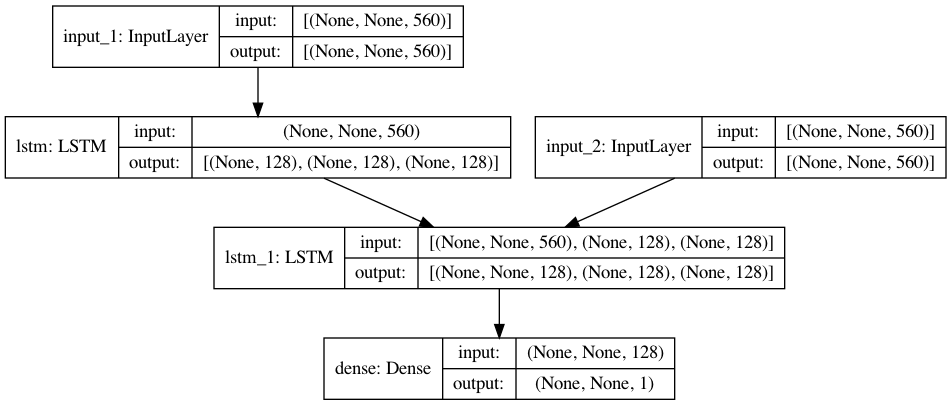

In [13]:
num_encoder_tokens = x_train.shape[2]
num_decoder_tokens = 1
hidden_units = 128

# Define an input sequence and process it.

encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = LSTM(hidden_units, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.

decoder_inputs = Input(shape=(None, num_encoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

#decoder_dropout = Dropout(0.5)

#decoder_outputs = decoder_dropout(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens)

decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='mse')

plot_model(model, to_file='model.png', show_shapes=True)

In [31]:
traslape = 100
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 25,batch_size=1 ,validation_split=0.1, shuffle = True)

Epoch 1/25
64/64 [==============================] - 23s 356ms/step - loss: 0.0151 - val_loss: 0.0111
Epoch 2/25
64/64 [==============================] - 25s 395ms/step - loss: 0.0113 - val_loss: 0.0100
Epoch 3/25
64/64 [==============================] - 25s 388ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 4/25
64/64 [==============================] - 26s 400ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 5/25
64/64 [==============================] - 23s 357ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 6/25
64/64 [==============================] - 23s 354ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 7/25
64/64 [==============================] - 22s 347ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 8/25
64/64 [==============================] - 22s 350ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 9/25
64/64 [==============================] - 22s 349ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 10/25
64/64 [==============================] - 22s 348ms/step - loss: 0.0070 - val_lo

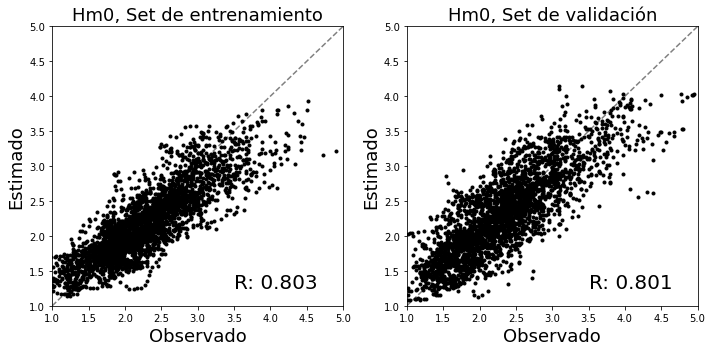

In [32]:
y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]])))

y_train = scy.inverse_transform(juntar(y_train))

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))



fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title('Hm0, Set de entrenamiento',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(y_train[:3000],y_pred_train[:3000],'.',color='Black')
axs[0].set_xlabel('Observado',size=18)
axs[0].set_ylabel('Estimado',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(y_train.T,(y_pred_train).T)[0,1],3)),size=20)


axs[1].set_title('Hm0, Set de validación',fontsize=18)
axs[1].plot([1,5],[1,5],'--',0.5,color='grey')
axs[1].plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs[1].set_xlabel('Observado',size=18)
axs[1].set_ylabel('Estimado',size=18)
axs[1].set_ylim(1,5)
axs[1].set_xlim(1,5)
axs[1].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(y_test.T,y_pred_test.T)[0,1],3)),size=20)

fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("New_LSTM_64_560_ts1000_100_fulldata_sinnorm",dpi=300)




In [33]:
'''Esto lo iré haciendo para guardar las variables'''


Hm0_test = y_test
Hm0_pred = y_pred_test

In [17]:
traslape = 100

x_train, x_test, y_train, y_test, scy = get_set(X, Tp, timestep= 1000, traslape = traslape)

X_train shape:  (72, 1100, 560)
Y_train shape:  (72, 1000, 1)


In [19]:

model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 35,batch_size=1 ,validation_split=0.1, shuffle = True)

Epoch 1/35
64/64 [==============================] - 27s 396ms/step - loss: 0.0121 - val_loss: 0.0129
Epoch 2/35
64/64 [==============================] - 27s 417ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 3/35
64/64 [==============================] - 25s 394ms/step - loss: 0.0116 - val_loss: 0.0123
Epoch 4/35
64/64 [==============================] - 24s 382ms/step - loss: 0.0119 - val_loss: 0.0140
Epoch 5/35
64/64 [==============================] - 25s 387ms/step - loss: 0.0117 - val_loss: 0.0128
Epoch 6/35
64/64 [==============================] - 25s 384ms/step - loss: 0.0119 - val_loss: 0.0158
Epoch 7/35
64/64 [==============================] - 23s 359ms/step - loss: 0.0118 - val_loss: 0.0134
Epoch 8/35
64/64 [==============================] - 24s 382ms/step - loss: 0.0119 - val_loss: 0.0119
Epoch 9/35
64/64 [==============================] - 33s 525ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 10/35
64/64 [==============================] - 27s 417ms/step - loss: 0.0113 - val_lo

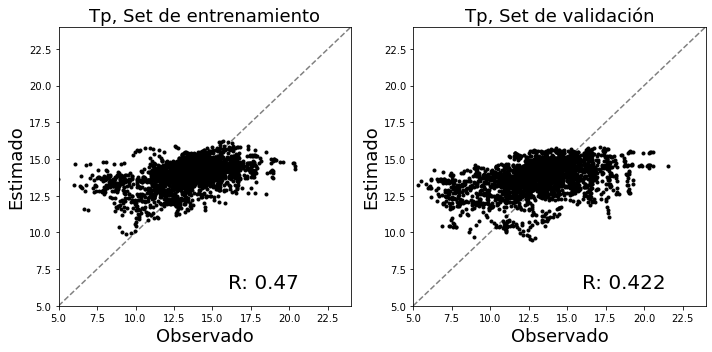

In [20]:
y_pred_train = scy.inverse_transform(juntar(model.predict([x_train[:,:traslape,:],x_train[:,traslape:,:]])))

y_train = scy.inverse_transform(juntar(y_train))

y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))



fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title('Tp, Set de entrenamiento',fontsize=18)
axs[0].plot([5,24],[5,24],'--',0.5,color='grey')
axs[0].plot(y_train[:3000],y_pred_train[:3000],'.',color='Black')
axs[0].set_xlabel('Observado',size=18)
axs[0].set_ylabel('Estimado',size=18)
axs[0].set_ylim(5,24)
axs[0].set_xlim(5,24)
axs[0].text(16,6.2,'R: '+str(np.round(np.corrcoef(y_train.T,(y_pred_train).T)[0,1],3)),size=20)


axs[1].set_title('Tp, Set de validación',fontsize=18)
axs[1].plot([5,24],[5,24],'--',0.5,color='grey')
axs[1].plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs[1].set_xlabel('Observado',size=18)
axs[1].set_ylabel('Estimado',size=18)
axs[1].set_ylim(5,24)
axs[1].set_xlim(5,24)
axs[1].text(16,6.2,'R: '+str(np.round(np.corrcoef(y_test.T,(y_pred_test).T)[0,1],3)),size=20)


fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("New_LSTM_64_560_ts1000_1_fulldata",dpi=300)





In [29]:
Tp_test = y_test
Tp_pred = y_pred_test

In [34]:
traslape = 100

x_train, x_test, y_train, y_test, scy = get_set(X, MD, timestep= 1000, traslape = traslape)
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 35,batch_size=1 ,validation_split=0.1, shuffle = True)

X_train shape:  (72, 1100, 560)
Y_train shape:  (72, 1000, 1)
Epoch 1/35
64/64 [==============================] - 22s 345ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 2/35
64/64 [==============================] - 25s 394ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 3/35
64/64 [==============================] - 24s 374ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 4/35
64/64 [==============================] - 23s 364ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/35
64/64 [==============================] - 23s 365ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 6/35
64/64 [==============================] - 24s 370ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/35
64/64 [==============================] - 23s 365ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 8/35
64/64 [==============================] - 23s 365ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/35
64/64 [==============================] - 24s 373ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 10/35
64/64 [==========

In [35]:
y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.corrcoef(y_test.T,(y_pred_test).T)[0,1]

0.8091833398462314

In [37]:
MD_test = y_test
MD_pred = y_pred_test

In [38]:
traslape = 100
x_train, x_test, y_train, y_test, scy = get_set(X, DSD, timestep= 1000, traslape = traslape)
model.fit([x_train[:,:traslape,:],x_train[:,traslape:,:]],y_train,epochs= 35,batch_size=1 ,validation_split=0.1, shuffle = True)

X_train shape:  (72, 1100, 560)
Y_train shape:  (72, 1000, 1)
Epoch 1/35
64/64 [==============================] - 22s 344ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 2/35
64/64 [==============================] - 24s 380ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 3/35
64/64 [==============================] - 23s 356ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 4/35
64/64 [==============================] - 24s 371ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 5/35
64/64 [==============================] - 23s 355ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 6/35
64/64 [==============================] - 23s 360ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 7/35
64/64 [==============================] - 22s 351ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 8/35
64/64 [==============================] - 25s 397ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 9/35
64/64 [==============================] - 24s 372ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 10/35
64/64 [==========

In [39]:
y_pred_test = scy.inverse_transform(juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

y_test = scy.inverse_transform(juntar(y_test))

np.corrcoef(y_test.T,(y_pred_test).T)[0,1]

0.6158233137738301

In [40]:
DSD_test = y_test
DSD_pred = y_pred_test

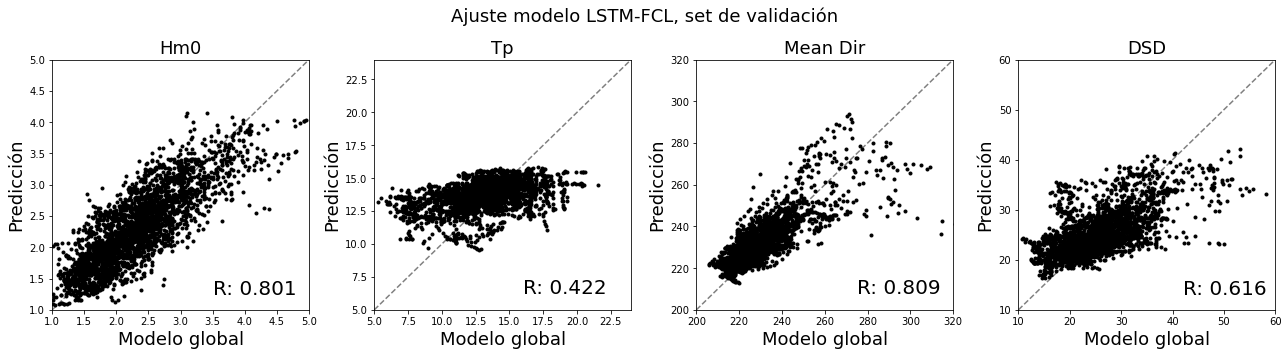

In [43]:
#y_pred = (juntar(model.predict([x_test[:,:traslape,:],x_test[:,traslape:,:]])))

#y_test = (juntar(y_test))


fig, axs = plt.subplots(1, 4, figsize=(18,5))

fig.suptitle('Ajuste modelo LSTM-FCL, set de validación',fontsize=18)


axs[0].set_title('Hm0',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(Hm0_test[:3000,0],Hm0_pred[:3000,0],'.',color='Black')
axs[0].set_xlabel('Modelo global',size=18)
axs[0].set_ylabel('Predicción',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(Hm0_test.T,(Hm0_pred).T)[0,1],3)),size=20)


axs[1].set_title('Tp',fontsize=18)
axs[1].plot([5,24],[5,24],'--',0.5,color='grey')
axs[1].plot(Tp_test[:3000],Tp_pred[:3000],'.',color='Black')
axs[1].set_xlabel('Modelo global',size=18)
axs[1].set_ylabel('Predicción',size=18)
axs[1].set_ylim(5,24)
axs[1].set_xlim(5,24)
axs[1].text(16,6.2,'R: '+str(np.round(np.corrcoef(Tp_test.T,(Tp_pred).T)[0,1],3)),size=20)

axs[2].set_title('Mean Dir',fontsize=18)
axs[2].plot([200,320],[200,320],'--',0.5,color='grey')
axs[2].plot(MD_test[:3000],MD_pred[:3000],'.',color='Black')
axs[2].set_xlabel('Modelo global',size=18)
axs[2].set_ylabel('Predicción',size=18)
axs[2].set_ylim(200,320)
axs[2].set_xlim(200,320)
axs[2].text(275,208,'R: '+str(np.round(np.corrcoef(MD_test.T,(MD_pred).T)[0,1],3)),size=20)

axs[3].set_title('DSD',fontsize=18)
axs[3].plot([10,60],[10,60],'--',0.5,color='grey')
axs[3].plot(DSD_test[:3000],DSD_pred[:3000],'.',color='Black')
axs[3].set_xlabel('Modelo global',size=18)
axs[3].set_ylabel('Predicción',size=18)
axs[3].set_ylim(10,60)
axs[3].set_xlim(10,60)
axs[3].text(42,13,'R: '+str(np.round(np.corrcoef(DSD_test.T,(DSD_pred).T)[0,1],3)),size=20)






fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("Variables_LSTM",dpi=300)